<html>
    <div style="background-color: lightskyblue; padding: 30px; color: black; text-align: center;">
    <h1>CAB420 - Assignment 2</h1>
    <h2>Building a DCNN Model to Classify Animals and Endangered Status</h2>
    </div>
</html>

Loading in the main modules for the project

In [1]:
import numpy as np
import pandas as pd
import os
import scipy
import matplotlib.pyplot as plt
import glob
import cv2
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import random

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

Utility Functions

In [2]:
def load_images_from_folders(root_dir):
    # Root directory is 256_ObjectCategories
    
    print(f"Loading images from {root_dir}")
    seen_paths = []
    unseen_paths = []
    # This is the main animals directory
    directories = os.listdir(root_dir)
    directories.sort()


    # This will have the animal directories
    for dirpath in directories:
        if dirpath != '.DS_Store':
            os.chdir(os.path.join(root_dir, dirpath))
            seen_unseen_dir = os.listdir(os.getcwd())
            seen_unseen_dir.sort()      
            seen_unseen_dir.pop(0)

            seen_image_count = 0
            unseen_image_count = 0
    #         # This is the seen and unseen directories
            for folder in seen_unseen_dir:
                # Go into the seen/unseen directory
                try:
                    os.chdir(os.path.join(root_dir, dirpath, folder))
                except:
                    print(f'Attempted to access directory {os.path.join(root_dir, dirpath, folder)} but it does not exist.')
                print(f"Current folder: {os.getcwd()}")
                # Grab the images in the seen/unseen directory
                images_in_dir = os.listdir(os.getcwd())
                images_in_dir.sort()

                # Append each of the images to the image_paths list
                for image in images_in_dir:
                    if folder == 'seen_images':
                        seen_paths.append(os.path.join(root_dir, dirpath, folder, image))
                        seen_image_count += 1
                        
                    elif folder == 'unseen_images':
                        unseen_paths.append(os.path.join(root_dir, dirpath, folder, image))
                        unseen_image_count += 1
                    else:
                        print(f"Unknown folder: {folder}")
                        continue

                    # Get out of the seen/unseen directory onto the animals directory
                    os.chdir('..')
                os.chdir('..')
            
            os.chdir('..')
    return seen_paths, unseen_paths

def read_images(image_paths):
    images = []
    for path in image_paths:
        try:
            img = np.array(Image.open(path)) # or img = cv2.imread(path)
            images.append(img)
        except Exception as e:
             print(f"Error loading image: {path} - {e}")    
    return images

# def eval_model(model, train, train_y, test, test_y):
#     fig = plt.figure(figsize=[20, 8])    

#     ax = fig.add_subplot(1, 2, 1)    
#     # predict on the training set
#     pred = model.predict(train, verbose=False);
#     # get indexes for the predictions and ground truth, this is converting back from a one-hot representation
#     # to a single index
#     indexes = tf.argmax(pred, axis=1)
#     gt_idx = tf.argmax(train_y, axis=1)

#     # plot the confusion matrix, I'm using tensorflow and seaborn here, but you could use
#     # sklearn as well
#     confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
#     sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
#             annot=True, fmt='g', ax=ax)
#     # set the title to the F1 scope
#     ax.set_title('Training, F1 Score: %f' % f1_score(gt_idx, indexes, average='weighted'))

#     # repeat visualisation for the test set
#     ax = fig.add_subplot(1, 2, 2)  
#     pred = model.predict(test, verbose=False);
#     indexes = tf.argmax(pred, axis=1)
#     gt_idx = tf.argmax(test_y, axis=1)

#     confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
#     sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
#             annot=True, fmt='g', ax=ax)
#     ax.set_title('Testing, F1 Score: %f' % f1_score(gt_idx, indexes, average='weighted'))

def eval_model(model, history, x_test, y_test):
    test_scores = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])

    pred = model.predict(x_test, verbose=False);
    indexes = keras.ops.argmax(pred, axis=1)
    
    cm = confusion_matrix(y_test, indexes)
    fig = plt.figure(figsize=[8, 8])
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)
    
    print(classification_report(y_test, indexes))

    fig = plt.figure(figsize=[8, 4])
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(history['loss'], label='Training Loss')
    ax.plot(history['accuracy'], label='Training Accuracy')
    ax.plot(history['val_loss'], label='Validation Loss')
    ax.plot(history['val_accuracy'], label='Validation Accuracy')
    ax.set_xlabel('Training Epochs')
    ax.set_ylabel('Accuracy or Loss')
    ax.legend()

    return [image_a, image_b, image_c]

def generate_pseudo_labels(seen_data, unseen_X_data, model, threshold = None):
    seen_train_X = seen_data['seen_train_X']
    species_labelled_train_Y = seen_data['species_labelled_train_Y']
    endangered_labelled_train_Y = seen_data['endangered_labelled_train_Y']

    if threshold is None:
        print('No threshold provided, need to specify a threshold for labelling')
        
    species_pseudo_labels = []
    endangered_pseudo_labels = []
    pseudo_images = []

    for i in range(len(unseen_X_data)):
        species_prediction, endangered_prediction = model.predict(unseen_X_data[i:i+1])
        
        species_task = tf.reduce_max(species_prediction, axis=1)
        endangered_task = tf.reduce_max(endangered_prediction, axis=1)

        mask = tf.logical_and(species_task >= threshold, endangered_task >= threshold)
        print(mask)
        
        selected_image = tf.boolean_mask(unseen_X_data[i:i+1], mask)

        selected_species = tf.boolean_mask(species_prediction, mask)
        selected_endangered = tf.boolean_mask(endangered_prediction, mask)

        pseudo_images.append(selected_image)
        species_pseudo_labels.append(selected_species)
        endangered_pseudo_labels.append(selected_endangered)

    pseudo_images = tf.concat(pseudo_images, axis=0)
    species_pseudo_labels = tf.concat(species_pseudo_labels, axis=0)
    endangered_pseudo_labels = tf.concat(endangered_pseudo_labels, axis=0)

    combine_images = tf.concat([seen_train_X, pseudo_images], axis=0)
    combine_species_labels = tf.concat([species_labelled_train_Y, species_pseudo_labels], axis=0)
    combine_endangered_labels = tf.concat([endangered_labelled_train_Y, endangered_pseudo_labels], axis=0)

    combine_dataset = tf.data.Dataset.from_tensor_slices(
        (combine_images, {'species_pred' : combine_species_labels, 'endangered_pred': combine_endangered_labels})
    )
    combine_dataset = combine_dataset.shuffle(1024).batch(32)

    print(f'Number of species pseudo labels: {len(combine_species_labels)}\nNumber of endangered pseudo labels: {len(combine_endangered_labels)}') 

    return combine_dataset, species_pseudo_labels, endangered_pseudo_labels, pseudo_images

In [3]:
image_root = '/Users/aidanlockwood/GitHub/CAB420-Codebase/Assessment/assignment_2/data/256_ObjectCategories'
seen_paths, unseen_paths = load_images_from_folders(image_root)

seen_images = read_images(seen_paths)
unseen_images = read_images(unseen_paths)


Loading images from /Users/aidanlockwood/GitHub/CAB420-Codebase/Assessment/assignment_2/data/256_ObjectCategories
Current folder: /Users/aidanlockwood/GitHub/CAB420-Codebase/Assessment/assignment_2/data/256_ObjectCategories/024.butterfly/seen_images
Current folder: /Users/aidanlockwood/GitHub/CAB420-Codebase/Assessment/assignment_2/data/256_ObjectCategories/024.butterfly/unseen_images
Current folder: /Users/aidanlockwood/GitHub/CAB420-Codebase/Assessment/assignment_2/data/256_ObjectCategories/028.camel/seen_images
Current folder: /Users/aidanlockwood/GitHub/CAB420-Codebase/Assessment/assignment_2/data/256_ObjectCategories/028.camel/unseen_images
Current folder: /Users/aidanlockwood/GitHub/CAB420-Codebase/Assessment/assignment_2/data/256_ObjectCategories/057.dolphin-101/seen_images
Current folder: /Users/aidanlockwood/GitHub/CAB420-Codebase/Assessment/assignment_2/data/256_ObjectCategories/057.dolphin-101/unseen_images
Current folder: /Users/aidanlockwood/GitHub/CAB420-Codebase/Assessme

Downloading the datasets

In [4]:
labelled_data = pd.read_csv("/Users/aidanlockwood/GitHub/CAB420-Codebase/Assessment/assignment_2/data/labelled_data.csv")
unlabelled_data = pd.read_csv("/Users/aidanlockwood/GitHub/CAB420-Codebase/Assessment/assignment_2/data/unlabelled_data.csv")

In [5]:
labelled_data = labelled_data[0:641]

In [6]:
unlabelled_data = unlabelled_data[0:647]

In [7]:
seen_paths = sorted(seen_paths)
unseen_paths = sorted(unseen_paths)

In [8]:
len(unseen_paths)

777

In [9]:
labelled_data.sort_values(by = 'filename_id', inplace = True)
unlabelled_data.sort_values(by = 'filename_id', inplace = True)

These images aren't in a standardised format. Going to implement a resize to keep them in the same format

In [10]:
seen_np_images = []
unseen_np_images = []

for i in range(len(seen_images)):
    image_np = np.array(seen_images[i])
    # If image is grayscale, convert to 3 channels
    if image_np.ndim == 2:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2RGB)
    image_np = cv2.resize(image_np, (256, 256))
    image_np = image_np.astype('float32')
    seen_np_images.append(image_np) 

for i in range(len(unseen_images)):
    image_np = np.array(unseen_images[i])
    # If image is grayscale, convert to 3 channels
    if image_np.ndim == 2:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2RGB)
    image_np = cv2.resize(image_np, (256, 256))
    image_np = image_np.astype('float32')
    unseen_np_images.append(image_np)

seen_np_images = np.array(seen_np_images)
unseen_np_images = np.array(unseen_np_images)


Organising the train/test split

In [11]:
len(labelled_data)

504

In [12]:
len(seen_paths)

515

In [13]:
sorted_list = sorted(labelled_data['filename_id'].to_list())

In [14]:
for i in range(len(sorted_list)):
    print({sorted_list[i] : seen_paths[i][-12:]})

{'024_0001': 'es/.DS_Store'}
{'024_0002': '024_0001.jpg'}
{'024_0003': '024_0002.jpg'}
{'024_0004': '024_0003.jpg'}
{'024_0005': '024_0004.jpg'}
{'024_0006': '024_0005.jpg'}
{'024_0007': '024_0006.jpg'}
{'024_0008': '024_0007.jpg'}
{'024_0009': '024_0008.jpg'}
{'024_0010': '024_0009.jpg'}
{'024_0011': '024_0010.jpg'}
{'024_0012': '024_0011.jpg'}
{'024_0013': '024_0012.jpg'}
{'024_0014': '024_0013.jpg'}
{'024_0015': '024_0014.jpg'}
{'024_0016': '024_0015.jpg'}
{'024_0017': '024_0016.jpg'}
{'024_0018': '024_0017.jpg'}
{'024_0019': '024_0018.jpg'}
{'024_0020': '024_0019.jpg'}
{'024_0021': '024_0020.jpg'}
{'024_0022': '024_0021.jpg'}
{'024_0023': '024_0022.jpg'}
{'024_0024': '024_0023.jpg'}
{'024_0025': '024_0024.jpg'}
{'024_0026': '024_0025.jpg'}
{'024_0027': '024_0026.jpg'}
{'024_0028': '024_0027.jpg'}
{'024_0029': '024_0028.jpg'}
{'024_0030': '024_0029.jpg'}
{'024_0031': '024_0030.jpg'}
{'024_0032': '024_0031.jpg'}
{'024_0033': '024_0032.jpg'}
{'024_0034': '024_0033.jpg'}
{'024_0035': '

In [15]:
seen_shapes = [img.shape for img in seen_images]
unseen_shapes = [img.shape for img in unseen_images]

print("Unique shapes in seen_images:", set(seen_shapes))
print("Unique shapes in unseen_images:", set(unseen_shapes))

# 2. Check for count mismatches
print("Number of seen images:", len(seen_images))
print("Number of seen labels:", len(labelled_data))
print("Number of unseen images:", len(unseen_images))
print("Number of unlabelled entries:", len(unlabelled_data))

# 3. Check for failed loads (None or wrong dtype)
failed_seen = [i for i, img in enumerate(seen_images) if img is None or not isinstance(img, np.ndarray)]
failed_unseen = [i for i, img in enumerate(unseen_images) if img is None or not isinstance(img, np.ndarray)]
print("Failed seen image indices:", failed_seen)
print("Failed unseen image indices:", failed_unseen)

Unique shapes in seen_images: {(291, 445, 3), (390, 500, 3), (1024, 768, 3), (480, 640, 3), (388, 350, 3), (525, 700, 3), (429, 640, 3), (600, 530, 3), (756, 500, 3), (355, 483, 3), (120, 160, 3), (734, 458, 3), (465, 640, 3), (281, 266, 3), (198, 144, 3), (488, 600, 3), (864, 1332, 3), (191, 283, 3), (450, 576, 3), (384, 512, 3), (350, 250, 3), (408, 532, 3), (236, 255, 3), (263, 388, 3), (768, 1024, 3), (284, 428, 3), (277, 210, 3), (326, 328, 3), (429, 411, 3), (274, 426, 3), (1065, 795, 3), (263, 350, 3), (308, 410, 3), (1024, 809, 3), (201, 200, 3), (360, 564, 3), (419, 600, 3), (261, 229, 3), (264, 400, 3), (420, 504, 3), (303, 360, 3), (723, 936, 3), (240, 197, 3), (218, 300, 3), (350, 340, 3), (1000, 647, 3), (460, 687, 3), (143, 216, 3), (400, 575, 3), (772, 1028, 3), (533, 450, 3), (232, 325, 3), (864, 1152, 3), (249, 249, 3), (720, 960, 3), (470, 500, 3), (533, 799, 3), (246, 350, 3), (324, 460, 3), (280, 410, 3), (287, 398, 3), (196, 161, 3), (207, 216, 3), (338, 600, 3), (

In [16]:
# Labelled data
seen_train_X, seen_test_X, species_labelled_train_Y, species_labelled_test_Y, endangered_labelled_train_Y, endangered_labelled_test_Y = train_test_split(seen_np_images, labelled_data['species'], labelled_data['endangered'], test_size=0.2, random_state=42)
species_labelled_train_Y = species_labelled_train_Y.reset_index(drop=True)

# Unlabelled data
unseen_train_X, unseen_test_X = train_test_split(unseen_np_images, test_size=0.2, random_state=42)


# Convert labels to one-hot encoding
species_labelled_train_Y = to_categorical(species_labelled_train_Y, num_classes = 13)
species_labelled_test_Y = to_categorical(species_labelled_test_Y, num_classes = 13)

endangered_labelled_train_Y = to_categorical(endangered_labelled_train_Y, num_classes = 5)
endangered_labelled_test_Y = to_categorical(endangered_labelled_test_Y, num_classes = 5)


In [17]:
endangered_labelled_train_Y.max()

1.0

In [18]:
len(unlabelled_data)

647

Visualising the images found

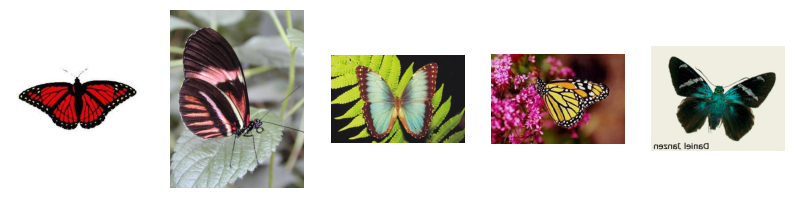

In [19]:
fig = plt.figure(figsize=(10, 10))

image_range = seen_images[0:5]

for i in range(len(image_range)):
    try:
        ax = fig.add_subplot(1, 5, i + 1)
        img = image_range[i]

        if img.max() > 1:
            img = img / 255.0
        ax.imshow(img)
        ax.axis('off')
    except:
        break
plt.show()

### Time to Build the Network

Creating an augmentation layer

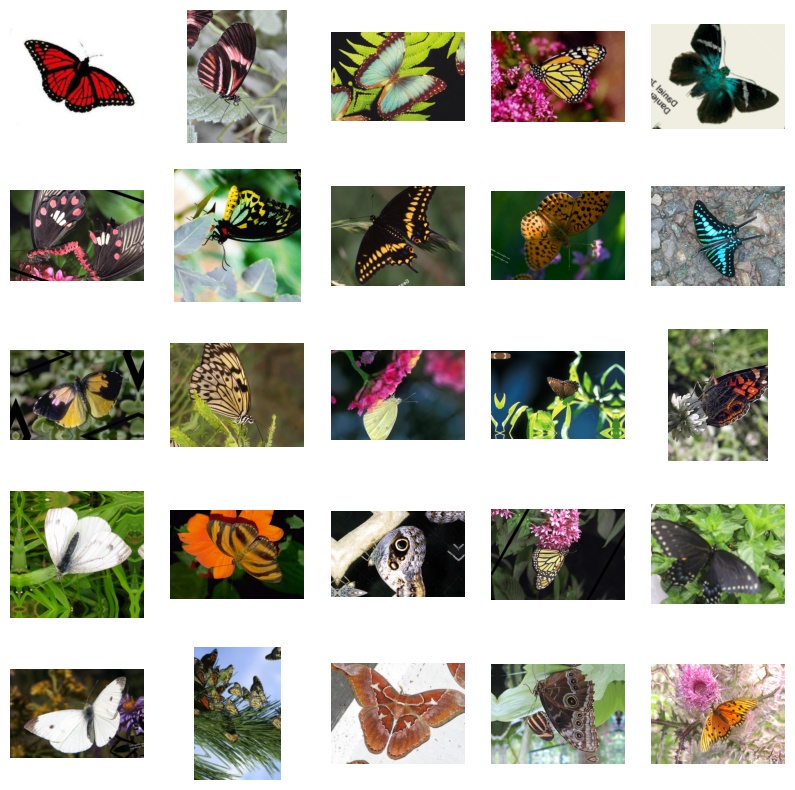

In [20]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

fig = plt.figure(figsize=(10, 10))
image_range = seen_images[0:50]
for i in range(len(image_range)):
    try:
        ax = fig.add_subplot(5, 5, i + 1)
        img = image_range[i]

        if img.max() > 1:
            img = img / 255.0
        ax.imshow(data_augmentation(img))
        ax.axis('off')
    except:
        break

plt.show()

Doing some normalisation for model training

In [21]:
seen_train_X = seen_train_X.astype('float32') / 255.0
seen_test_X = seen_test_X.astype('float32') / 255.0
unseen_train_X = unseen_train_X.astype('float32') / 255.0
unseen_test_X = unseen_test_X.astype('float32') / 255.0

In [22]:
unseen_train_X

array([[[[0.21960784, 0.23137255, 0.23921569],
         [0.20784314, 0.22352941, 0.22745098],
         [0.19215687, 0.20784314, 0.21176471],
         ...,
         [0.5764706 , 0.56078434, 0.5647059 ],
         [0.5372549 , 0.5176471 , 0.53333336],
         [0.5137255 , 0.49411765, 0.50980395]],

        [[0.30588236, 0.30980393, 0.31764707],
         [0.28235295, 0.28627452, 0.29411766],
         [0.24705882, 0.2509804 , 0.25882354],
         ...,
         [0.5529412 , 0.54901963, 0.54901963],
         [0.52156866, 0.5137255 , 0.5176471 ],
         [0.4745098 , 0.46666667, 0.47058824]],

        [[0.3647059 , 0.3647059 , 0.36862746],
         [0.34509805, 0.34901962, 0.34901962],
         [0.3137255 , 0.31764707, 0.31764707],
         ...,
         [0.5411765 , 0.5372549 , 0.53333336],
         [0.5137255 , 0.5137255 , 0.5058824 ],
         [0.45882353, 0.45490196, 0.4509804 ]],

        ...,

        [[0.70980394, 0.6862745 , 0.7019608 ],
         [0.6666667 , 0.64705884, 0.6627451 ]

In [ ]:
def residual_block(x, filters, downsample=False):
    shortcut = x

    # First conv block
    x = layers.Conv2D(filters, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Second conv block (optionally downsampling)
    if downsample:
        x = layers.Conv2D(filters, (3, 3), strides=2, padding='same', use_bias=False)(x)
    else:
        x = layers.Conv2D(filters, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Shortcut connection
    if downsample or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=(2 if downsample else 1),
                                 padding='same', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Residual addition
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x


input_layer = layers.Input(shape=(256, 256, 3), name='input_image')

# x = layers.Resizing(256, 256)(input_layer)
# x = layers.RandomFlip("horizontal_and_vertical")(x)
# x = layers.RandomRotation(0.2)(x)
# x = layers.RandomZoom(0.2)(x)

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
x = layers.Activation('relu')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.SpatialDropout2D(0.1)(x)
x = layers.MaxPooling2D()(x)

x = residual_block(x, 32, downsample=True)
x = layers.MaxPooling2D()(x)
# x = residual_block(x, 64, downsample=True)
# x = layers.MaxPooling2D()(x)
# x = residual_block(x, 128, downsample=True)
# x = layers.MaxPooling2D()(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
x_1 = layers.Dense(64, activation='relu')(x)
output_1 = layers.Dense(13, activation='softmax', name='species_pred')(x_1)
x_2 = layers.Dense(64, activation='relu')(x)
output_2 = layers.Dense(5, activation='softmax', name='endangered_pred')(x_2)

model = keras.Model(inputs=input_layer, outputs=[output_1, output_2])   

model.summary()

from tensorflow.keras.utils import plot_model

# Assuming you've already built the model:
plot_model(model, to_file="resnet_custom_model.png", show_shapes=True, show_layer_names=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_image[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d   │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (SpatialDropout2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ spatial_dropout2… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,608 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,216 │ activation_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │        512 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ activation_2[0][

 Total params: 29,154 (113.88 KB)

 Trainable params: 28,930 (113.01 KB)

 Non-trainable params: 224 (896.00 B)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [24]:
endangered_labelled_test_Y.max()

1.0

Initial training

In [25]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0001), loss = {
	'species_pred': 'categorical_crossentropy',
	'endangered_pred': 'categorical_crossentropy'
	}, metrics = ['accuracy', 'accuracy'], jit_compile=False)

history = model.fit(
	seen_train_X,
	[species_labelled_train_Y, endangered_labelled_train_Y],
	epochs=10,
	batch_size=32,
	validation_data=(seen_test_X, [species_labelled_test_Y, endangered_labelled_test_Y]),
	verbose=1
)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - endangered_pred_accuracy: 0.2562 - endangered_pred_loss: 1.5974 - loss: 4.2217 - species_pred_accuracy: 0.0631 - species_pred_loss: 2.6244 - val_endangered_pred_accuracy: 0.5644 - val_endangered_pred_loss: 1.6021 - val_loss: 4.1666 - val_species_pred_accuracy: 0.0594 - val_species_pred_loss: 2.5661
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - endangered_pred_accuracy: 0.3829 - endangered_pred_loss: 1.5457 - loss: 4.1406 - species_pred_accuracy: 0.0669 - species_pred_loss: 2.5947 - val_endangered_pred_accuracy: 0.5743 - val_endangered_pred_loss: 1.5913 - val_loss: 4.1566 - val_species_pred_accuracy: 0.0198 - val_species_pred_loss: 2.5669
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - endangered_pred_accuracy: 0.4258 - endangered_pred_loss: 1.5018 - loss: 4.0654 - species_pred_accuracy: 0.1026 - species_pred_loss: 2.5634 - val_endangered_pred_accuracy: 0.5743 - val_endangered_pred_loss: 1.5772 - val_loss: 4.1429 - val_specie

Regenerating pseudo labels for another iteration

In [26]:
pseudo_images = []
species_pseudo_labels = []
endangered_pseudo_labels = []

for i in range(len(unseen_train_X)):
    species_prediction, endangered_prediction = model.predict(unseen_train_X[i:i+1])

    species_task = tf.reduce_max(species_prediction, axis=1)
    endangered_task = tf.reduce_max(endangered_prediction, axis=1)

    mask = tf.logical_and(species_task >= 0.7, endangered_task >= 0.7)

    selected_images = tf.boolean_mask(unseen_train_X[i:i+1], mask)
    selected_species = tf.boolean_mask(species_prediction, mask)
    selected_endangered = tf.boolean_mask(endangered_prediction, mask)

    pseudo_images.append(selected_images)
    species_pseudo_labels.append(selected_species)
    endangered_pseudo_labels.append(selected_endangered)

pseudo_images = tf.concat(pseudo_images, axis=0)
species_pseudo_labels = tf.concat(species_pseudo_labels, axis=0)
endangered_pseudo_labels = tf.concat(endangered_pseudo_labels, axis=0)

combined_images = tf.concat([seen_train_X, pseudo_images], axis=0)
combined_species_labels = tf.concat([species_labelled_train_Y, species_pseudo_labels], axis=0)
combined_endangered_labels = tf.concat([endangered_labelled_train_Y, endangered_pseudo_labels], axis=0)


combine_dataset = tf.data.Dataset.from_tensor_slices(
    (combined_images, {'species_pred': combined_species_labels, 'endangered_pred': combined_endangered_labels})
)
combine_dataset = combine_dataset.shuffle(1000).batch(32)

print(len(species_pseudo_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━

In [27]:
history_2 = model.fit(
    combine_dataset,
    epochs=10,
    validation_data=(seen_test_X, [species_labelled_test_Y, endangered_labelled_test_Y]),
)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - endangered_pred_accuracy: 0.4316 - endangered_pred_loss: 1.3654 - loss: 3.7254 - species_pred_accuracy: 0.2129 - species_pred_loss: 2.3598 - val_endangered_pred_accuracy: 0.5743 - val_endangered_pred_loss: 1.4673 - val_loss: 4.0282 - val_species_pred_accuracy: 0.1386 - val_species_pred_loss: 2.5581
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - endangered_pred_accuracy: 0.4446 - endangered_pred_loss: 1.3443 - loss: 3.6886 - species_pred_accuracy: 0.2216 - species_pred_loss: 2.3444 - val_endangered_pred_accuracy: 0.5743 - val_endangered_pred_loss: 1.4574 - val_loss: 4.0163 - val_species_pred_accuracy: 0.1287 - val_species_pred_loss: 2.5554
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - endangered_pred_accuracy: 0.4227 - endangered_pred_loss: 1.3838 - loss: 3.7471 - species_pred_accuracy: 0.2056 - species_pred_loss: 2.3620 - val_endangered_pred_accuracy: 0.5743 - val_endangered_pred_loss: 1.4505 - val_loss: 4.0073 - val_specie

Second iteration

In [28]:
pseudo_images = []
species_pseudo_labels = []
endangered_pseudo_labels = []

for i in range(len(unseen_train_X)):
    species_prediction, endangered_prediction = model.predict(unseen_train_X[i:i+1])

    species_task = tf.reduce_max(species_prediction, axis=1)
    endangered_task = tf.reduce_max(endangered_prediction, axis=1)

    mask = tf.logical_and(species_task >= 0.7, endangered_task >= 0.7)

    selected_images = tf.boolean_mask(unseen_train_X[i:i+1], mask)
    selected_species = tf.boolean_mask(species_prediction, mask)
    selected_endangered = tf.boolean_mask(endangered_prediction, mask)

    pseudo_images.append(selected_images)
    species_pseudo_labels.append(selected_species)
    endangered_pseudo_labels.append(selected_endangered)

pseudo_images = tf.concat(pseudo_images, axis=0)
species_pseudo_labels = tf.concat(species_pseudo_labels, axis=0)
endangered_pseudo_labels = tf.concat(endangered_pseudo_labels, axis=0)

combined_images = tf.concat([seen_train_X, pseudo_images], axis=0)
combined_species_labels = tf.concat([species_labelled_train_Y, species_pseudo_labels], axis=0)
combined_endangered_labels = tf.concat([endangered_labelled_train_Y, endangered_pseudo_labels], axis=0)


combine_dataset = tf.data.Dataset.from_tensor_slices(
    (combined_images, {'species_pred': combined_species_labels, 'endangered_pred': combined_endangered_labels})
)
combine_dataset = combine_dataset.shuffle(1000).batch(32)

print(len(species_pseudo_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

In [29]:
history_3 = model.fit(
    combine_dataset,
    epochs = 5,
    validation_data = (seen_test_X, [species_labelled_test_Y, endangered_labelled_test_Y]),
    batch_size = 16
)

Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - endangered_pred_accuracy: 0.4287 - endangered_pred_loss: 1.3670 - loss: 3.6185 - species_pred_accuracy: 0.2622 - species_pred_loss: 2.2514 - val_endangered_pred_accuracy: 0.5743 - val_endangered_pred_loss: 1.3986 - val_loss: 3.9234 - val_species_pred_accuracy: 0.1683 - val_species_pred_loss: 2.5192
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - endangered_pred_accuracy: 0.4687 - endangered_pred_loss: 1.3106 - loss: 3.4853 - species_pred_accuracy: 0.2834 - species_pred_loss: 2.1735 - val_endangered_pred_accuracy: 0.5743 - val_endangered_pred_loss: 1.3891 - val_loss: 3.9060 - val_species_pred_accuracy: 0.1683 - val_species_pred_loss: 2.5102
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - endangered_pred_accuracy: 0.4612 - endangered_pred_loss: 1.3214 - loss: 3.5271 - species_pred_accuracy: 0.2642 - species_pred_loss: 2.2053 - val_endangered_pred_accuracy: 0.5743 - val_endangered_pred_loss: 1.3810 - val_loss: 3.8921 - val_species_p

In [30]:
pseudo_images = []
species_pseudo_labels = []
endangered_pseudo_labels = []

for i in range(len(unseen_train_X)):
    species_prediction, endangered_prediction = model.predict(unseen_train_X[i:i+1])

    species_task = tf.reduce_max(species_prediction, axis=1)
    endangered_task = tf.reduce_max(endangered_prediction, axis=1)

    mask = tf.logical_and(species_task >= 0.8, endangered_task >= 0.8)

    selected_images = tf.boolean_mask(unseen_train_X[i:i+1], mask)
    selected_species = tf.boolean_mask(species_prediction, mask)
    selected_endangered = tf.boolean_mask(endangered_prediction, mask)

    pseudo_images.append(selected_images)
    species_pseudo_labels.append(selected_species)
    endangered_pseudo_labels.append(selected_endangered)

pseudo_images = tf.concat(pseudo_images, axis=0)
species_pseudo_labels = tf.concat(species_pseudo_labels, axis=0)
endangered_pseudo_labels = tf.concat(endangered_pseudo_labels, axis=0)

combined_images = tf.concat([seen_train_X, pseudo_images], axis=0)
combined_species_labels = tf.concat([species_labelled_train_Y, species_pseudo_labels], axis=0)
combined_endangered_labels = tf.concat([endangered_labelled_train_Y, endangered_pseudo_labels], axis=0)


combine_dataset = tf.data.Dataset.from_tensor_slices(
    (combined_images, {'species_pred': combined_species_labels, 'endangered_pred': combined_endangered_labels})
)
combine_dataset = combine_dataset.shuffle(1000).batch(32)

print(len(species_pseudo_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

Third Iteration

In [31]:
history_4 = model.fit(
    combine_dataset,
    epochs = 5,
    validation_data = (seen_test_X, [species_labelled_test_Y, endangered_labelled_test_Y]),
    batch_size = 16
)

Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - endangered_pred_accuracy: 0.4934 - endangered_pred_loss: 1.2945 - loss: 3.5175 - species_pred_accuracy: 0.2248 - species_pred_loss: 2.2213 - val_endangered_pred_accuracy: 0.5743 - val_endangered_pred_loss: 1.3548 - val_loss: 3.8435 - val_species_pred_accuracy: 0.1683 - val_species_pred_loss: 2.4766
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - endangered_pred_accuracy: 0.4905 - endangered_pred_loss: 1.2493 - loss: 3.3570 - species_pred_accuracy: 0.3100 - species_pred_loss: 2.1073 - val_endangered_pred_accuracy: 0.5941 - val_endangered_pred_loss: 1.3430 - val_loss: 3.8163 - val_species_pred_accuracy: 0.1683 - val_species_pred_loss: 2.4577
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - endangered_pred_accuracy: 0.5012 - endangered_pred_loss: 1.2930 - loss: 3.4575 - species_pred_accuracy: 0.3017 - species_pred_loss: 2.1640 - val_endangered_pred_accuracy: 0.5941 - val_endangered_pred_loss: 1.3357 - val_loss: 3.8020 - val_species_p

In [32]:
pseudo_images = []
species_pseudo_labels = []
endangered_pseudo_labels = []

for i in range(len(unseen_train_X)):
    species_prediction, endangered_prediction = model.predict(unseen_train_X[i:i+1])

    species_task = tf.reduce_max(species_prediction, axis=1)
    endangered_task = tf.reduce_max(endangered_prediction, axis=1)

    mask = tf.logical_and(species_task >= 0.8, endangered_task >= 0.8)

    selected_images = tf.boolean_mask(unseen_train_X[i:i+1], mask)
    selected_species = tf.boolean_mask(species_prediction, mask)
    selected_endangered = tf.boolean_mask(endangered_prediction, mask)

    pseudo_images.append(selected_images)
    species_pseudo_labels.append(selected_species)
    endangered_pseudo_labels.append(selected_endangered)

pseudo_images = tf.concat(pseudo_images, axis=0)
species_pseudo_labels = tf.concat(species_pseudo_labels, axis=0)
endangered_pseudo_labels = tf.concat(endangered_pseudo_labels, axis=0)

combined_images = tf.concat([seen_train_X, pseudo_images], axis=0)
combined_species_labels = tf.concat([species_labelled_train_Y, species_pseudo_labels], axis=0)
combined_endangered_labels = tf.concat([endangered_labelled_train_Y, endangered_pseudo_labels], axis=0)


combine_dataset = tf.data.Dataset.from_tensor_slices(
    (combined_images, {'species_pred': combined_species_labels, 'endangered_pred': combined_endangered_labels})
)
combine_dataset = combine_dataset.shuffle(1000).batch(32)

print(len(species_pseudo_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━